# Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder
import datetime

from tqdm import tqdm
from fbprophet import Prophet

import lightgbm as lgb

In [2]:
import holidays

In [3]:
for date in holidays.UnitedStates(years=2019).items():
    print(date)

(datetime.date(2019, 1, 1), "New Year's Day")
(datetime.date(2019, 1, 21), 'Martin Luther King, Jr. Day')
(datetime.date(2019, 2, 18), "Washington's Birthday")
(datetime.date(2019, 5, 27), 'Memorial Day')
(datetime.date(2019, 7, 4), 'Independence Day')
(datetime.date(2019, 9, 2), 'Labor Day')
(datetime.date(2019, 10, 14), 'Columbus Day')
(datetime.date(2019, 11, 11), 'Veterans Day')
(datetime.date(2019, 11, 28), 'Thanksgiving')
(datetime.date(2019, 12, 25), 'Christmas Day')


In [4]:
for date in holidays.UnitedStates(years=2018).items():
    print(date)

(datetime.date(2018, 1, 1), "New Year's Day")
(datetime.date(2018, 1, 15), 'Martin Luther King, Jr. Day')
(datetime.date(2018, 2, 19), "Washington's Birthday")
(datetime.date(2018, 5, 28), 'Memorial Day')
(datetime.date(2018, 7, 4), 'Independence Day')
(datetime.date(2018, 9, 3), 'Labor Day')
(datetime.date(2018, 10, 8), 'Columbus Day')
(datetime.date(2018, 11, 11), 'Veterans Day')
(datetime.date(2018, 11, 12), 'Veterans Day (Observed)')
(datetime.date(2018, 11, 22), 'Thanksgiving')
(datetime.date(2018, 12, 25), 'Christmas Day')


In [5]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])

In [6]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro Bronx',
        'Triboro Manhattan',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [7]:
df = return_series('mta.csv')

In [8]:
_df = df.unstack().T

In [9]:
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [10]:
_df = _df.reset_index()
_df

plaza_id,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro Bronx,Triboro Manhattan,Verrazano,Whitestone
0,2018-01-01,29163,13705,46540,12118,54907,98346,110224,30551,81923,109286
1,2018-01-02,47160,21875,60610,19887,67000,106264,129574,35356,95649,117211
2,2018-01-03,54005,24607,67983,22067,71725,115952,136213,38937,103506,123974
3,2018-01-04,20484,8303,14502,6167,26625,28406,50867,13270,37820,38114
4,2018-01-05,38007,16839,49850,13929,55153,80477,105945,29308,74375,91229
...,...,...,...,...,...,...,...,...,...,...,...
981,2020-09-08,55105,24644,60591,25524,66662,106502,130435,34153,100146,121270
982,2020-09-09,56553,22692,62026,22821,67238,104707,128069,35541,99250,118513
983,2020-09-10,55672,20742,60627,20495,65909,100158,125216,34303,97574,114546
984,2020-09-11,56878,24493,70659,24483,73386,111209,139712,39046,107214,131970


In [11]:
_df.columns

Index(['datetime', 'Brooklyn Battery', 'Cross Bay', 'Henry Hudson',
       'Marine Parkway', 'Queens Midtown', 'Throgs Neck', 'Triboro Bronx',
       'Triboro Manhattan', 'Verrazano', 'Whitestone'],
      dtype='object', name='plaza_id')

In [12]:
_df_melt = pd.melt(_df, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro Bronx',
                                                        'Triboro Manhattan', 'Verrazano', 'Whitestone'])
_df_melt.set_index('datetime', inplace=True)
_df_melt

,plaza_id,value
datetime,,
2018-01-01,Brooklyn Battery,29163
2018-01-02,Brooklyn Battery,47160
2018-01-03,Brooklyn Battery,54005
2018-01-04,Brooklyn Battery,20484
2018-01-05,Brooklyn Battery,38007
...,...,...
2020-09-08,Whitestone,121270
2020-09-09,Whitestone,118513
2020-09-10,Whitestone,114546


In [13]:

def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter


    conditions = [
        (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4
    ]

    _df['Phase'] = np.select(conditions, choices, 5)
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    
    return _df

In [14]:
_df_melt = date_features(_df_melt)
_df_melt.reset_index(inplace=True)

In [15]:
conditions = [
    _df_melt['plaza_id'].eq('Triboro Bronx'),
    _df_melt['plaza_id'].eq('Triboro Manhattan'),
    _df_melt['plaza_id'].eq('Whitestone'),
    _df_melt['plaza_id'].eq('Henry Hudson'),
    _df_melt['plaza_id'].eq('Marine Parkway'),
    _df_melt['plaza_id'].eq('Cross Bay'),
    _df_melt['plaza_id'].eq('Queens Midtown'),
    _df_melt['plaza_id'].eq('Brooklyn Battery'),
    _df_melt['plaza_id'].eq('Throgs Neck'),
    _df_melt['plaza_id'].eq('Verrazano')
    
]
choices = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10
]

_df_melt['plaza_id'] = np.select(conditions, choices, 0)
_df_melt

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,1
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,0
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,0
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,0
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,121270,9,1,2020,37,8,3,4,0,0
9856,2020-09-09,3,118513,9,2,2020,37,9,3,4,0,0
9857,2020-09-10,3,114546,9,3,2020,37,10,3,4,0,0
9858,2020-09-11,3,131970,9,4,2020,37,11,3,4,0,0


In [16]:
train_set = _df_melt.loc[_df_melt['datetime'] <= '2020-08-22'].copy()
test_set = _df_melt.loc[_df_melt['datetime'] > '2020-08-22'].copy()
# test_set

In [17]:
# train_set

In [18]:
train_set['lag_7'] = train_set[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
train_set['lag_28'] = train_set[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
train_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,1,NaN,NaN
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,0,NaN,NaN
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,0,NaN,NaN
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,0,NaN,NaN
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2020-08-18,3,123407,8,1,2020,34,18,3,4,0,0,123273.0,114042.0
9835,2020-08-19,3,122248,8,2,2020,34,19,3,4,0,0,116497.0,112825.0
9836,2020-08-20,3,136581,8,3,2020,34,20,3,4,0,0,122549.0,115346.0
9837,2020-08-21,3,146062,8,4,2020,34,21,3,4,0,0,141229.0,127859.0


In [19]:
train_set['mean_lag7_roll7'] = train_set[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(7).mean())
train_set['mean_lag7_roll28'] = train_set[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(28).mean())
train_set['mean_lag28_roll7'] = train_set[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(7).mean())
train_set['mean_lag28_roll28'] = train_set[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(28).mean())
train_set['week'] = train_set['week'].astype('int64')
train_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2020-08-18,3,123407,8,1,2020,34,18,3,4,0,0,123273.0,114042.0,126017.571429,119920.464286,115296.571429,110016.607143
9835,2020-08-19,3,122248,8,2,2020,34,19,3,4,0,0,116497.0,112825.0,124832.000000,120017.928571,115161.857143,110290.714286
9836,2020-08-20,3,136581,8,3,2020,34,20,3,4,0,0,122549.0,115346.0,124196.428571,120275.142857,115161.714286,110454.714286
9837,2020-08-21,3,146062,8,4,2020,34,21,3,4,0,0,141229.0,127859.0,126062.571429,120858.142857,115583.714286,110688.392857


In [22]:
categorical_features = ['plaza_id', 'month', 'dayofweek', 'year', 'week', 'day', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value']
train_cols = train_set.columns[~train_set.columns.isin(useless_cols)]
_X = train_set[train_cols]
_y = train_set['value']

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [32]:
# y_valid

In [33]:
# y_train

In [34]:

train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)

y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features,
                             free_raw_data=False)  

In [295]:
import optuna

In [312]:
def objective(trial):
    params = {
        'objective': 'poisson',
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 18, 54),
        'num_leaves': trial.suggest_int('num_leaves', 36, 108),
#         'n_estimators': trial.suggest_int('n_estimators', 200, 400),
        'metric' :'rmse',
#         "force_row_wise" : True,
        "learning_rate" : 0.05,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        "lambda_l1" : trial.suggest_loguniform('l2', 0.1, 0.3),

    'verbosity': 1,
#     'num_iterations' : 200,
    'num_iterations' : 1000
#     'device_type': 'gpu'
    }
    m_lgb = lgb.train(params, train_data, valid_sets = y_valid_data, verbose_eval=100)
    
    loss = np.sqrt(mean_squared_error(m_lgb.predict(X_valid), y_valid))
    
    return loss

In [313]:
study = optuna.create_study()
study.optimize(objective, n_trials=100)

[100]	valid_0's rmse: 10398.2
[200]	valid_0's rmse: 8941.15
[300]	valid_0's rmse: 8061.15
[400]	valid_0's rmse: 7600.15
[500]	valid_0's rmse: 7414.76
[600]	valid_0's rmse: 7275.41
[700]	valid_0's rmse: 7174.32
[800]	valid_0's rmse: 7127.49
[900]	valid_0's rmse: 7084.62
[1000]	valid_0's rmse: 7045.63


[I 2020-09-18 15:05:14,229] Finished trial#0 with value: 7045.634737133359 with parameters: {'max_depth': 33, 'num_leaves': 59, 'bag_frac': 0.8248821253609473, 'feat_frac': 0.5936570985687558, 'l2': 0.16020111168714246}. Best is trial#0 with value: 7045.634737133359.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10307.4
[200]	valid_0's rmse: 8724.72
[300]	valid_0's rmse: 7795.35
[400]	valid_0's rmse: 7383.96
[500]	valid_0's rmse: 7194.68
[600]	valid_0's rmse: 7119.09
[700]	valid_0's rmse: 7074.92
[800]	valid_0's rmse: 7047.06
[900]	valid_0's rmse: 7020.22
[1000]	valid_0's rmse: 7000.12


[I 2020-09-18 15:05:58,036] Finished trial#1 with value: 7000.1214563785325 with parameters: {'max_depth': 19, 'num_leaves': 82, 'bag_frac': 0.6147035152844094, 'feat_frac': 0.7724076406005712, 'l2': 0.194312856139311}. Best is trial#1 with value: 7000.1214563785325.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10425.6
[200]	valid_0's rmse: 8952.83
[300]	valid_0's rmse: 8035.31
[400]	valid_0's rmse: 7567.95
[500]	valid_0's rmse: 7388.85
[600]	valid_0's rmse: 7249.54
[700]	valid_0's rmse: 7141.06
[800]	valid_0's rmse: 7071.48
[900]	valid_0's rmse: 7029.31
[1000]	valid_0's rmse: 6992.75


[I 2020-09-18 15:06:05,249] Finished trial#2 with value: 6992.745913185766 with parameters: {'max_depth': 32, 'num_leaves': 45, 'bag_frac': 0.5545301427981445, 'feat_frac': 0.6373985552248006, 'l2': 0.18561692867324495}. Best is trial#2 with value: 6992.745913185766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10321.9
[200]	valid_0's rmse: 8800.93
[300]	valid_0's rmse: 7901.13
[400]	valid_0's rmse: 7503
[500]	valid_0's rmse: 7334.65
[600]	valid_0's rmse: 7237.41
[700]	valid_0's rmse: 7185.3
[800]	valid_0's rmse: 7138.38
[900]	valid_0's rmse: 7105.92
[1000]	valid_0's rmse: 7083.5


[I 2020-09-18 15:07:28,164] Finished trial#3 with value: 7083.4986878050995 with parameters: {'max_depth': 38, 'num_leaves': 85, 'bag_frac': 0.6153520405318608, 'feat_frac': 0.6450984731799039, 'l2': 0.19164026923295294}. Best is trial#2 with value: 6992.745913185766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10283.9
[200]	valid_0's rmse: 8679.76
[300]	valid_0's rmse: 7760.19
[400]	valid_0's rmse: 7375.76
[500]	valid_0's rmse: 7222.48
[600]	valid_0's rmse: 7135.37
[700]	valid_0's rmse: 7101.31
[800]	valid_0's rmse: 7081.03
[900]	valid_0's rmse: 7059.38
[1000]	valid_0's rmse: 7050.55


[I 2020-09-18 15:08:30,674] Finished trial#4 with value: 7050.553984775579 with parameters: {'max_depth': 34, 'num_leaves': 104, 'bag_frac': 0.5448362002753218, 'feat_frac': 0.8033071598720639, 'l2': 0.10604529461131393}. Best is trial#2 with value: 6992.745913185766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10304
[200]	valid_0's rmse: 8828.54
[300]	valid_0's rmse: 7926.78
[400]	valid_0's rmse: 7495.84
[500]	valid_0's rmse: 7319.67
[600]	valid_0's rmse: 7223.17
[700]	valid_0's rmse: 7157.4
[800]	valid_0's rmse: 7116.89
[900]	valid_0's rmse: 7098.42
[1000]	valid_0's rmse: 7079.89


[I 2020-09-18 15:09:27,285] Finished trial#5 with value: 7079.89215500137 with parameters: {'max_depth': 51, 'num_leaves': 108, 'bag_frac': 0.6771209415477704, 'feat_frac': 0.5433818337566771, 'l2': 0.22843130123980307}. Best is trial#2 with value: 6992.745913185766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10409.3
[200]	valid_0's rmse: 8897.22
[300]	valid_0's rmse: 7880.96
[400]	valid_0's rmse: 7419.64
[500]	valid_0's rmse: 7198.8
[600]	valid_0's rmse: 7051.53
[700]	valid_0's rmse: 6962.44
[800]	valid_0's rmse: 6894.05
[900]	valid_0's rmse: 6845.96
[1000]	valid_0's rmse: 6817.07


[I 2020-09-18 15:09:32,790] Finished trial#6 with value: 6817.0733016766 with parameters: {'max_depth': 44, 'num_leaves': 40, 'bag_frac': 0.5600608873817355, 'feat_frac': 0.7562509866214401, 'l2': 0.10296686679826422}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10334.7
[200]	valid_0's rmse: 8856.39
[300]	valid_0's rmse: 7994.82
[400]	valid_0's rmse: 7579.31
[500]	valid_0's rmse: 7397.48
[600]	valid_0's rmse: 7280.32
[700]	valid_0's rmse: 7207.29
[800]	valid_0's rmse: 7160.91
[900]	valid_0's rmse: 7125.4
[1000]	valid_0's rmse: 7098.63


[I 2020-09-18 15:11:46,560] Finished trial#7 with value: 7098.627825678523 with parameters: {'max_depth': 53, 'num_leaves': 82, 'bag_frac': 0.5695835719877108, 'feat_frac': 0.5753886534961279, 'l2': 0.16319600976300247}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10312.6
[200]	valid_0's rmse: 8697.74
[300]	valid_0's rmse: 7796.63
[400]	valid_0's rmse: 7396.41
[500]	valid_0's rmse: 7226.84
[600]	valid_0's rmse: 7155.99
[700]	valid_0's rmse: 7122.52
[800]	valid_0's rmse: 7090.92
[900]	valid_0's rmse: 7070.88
[1000]	valid_0's rmse: 7047.83


[I 2020-09-18 15:12:05,929] Finished trial#8 with value: 7047.831510660827 with parameters: {'max_depth': 26, 'num_leaves': 85, 'bag_frac': 0.8758341275343192, 'feat_frac': 0.8030126259001245, 'l2': 0.14621229706319863}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10270
[200]	valid_0's rmse: 8581.09
[300]	valid_0's rmse: 7684.82
[400]	valid_0's rmse: 7304.16
[500]	valid_0's rmse: 7176.13
[600]	valid_0's rmse: 7118.59
[700]	valid_0's rmse: 7085.07
[800]	valid_0's rmse: 7057.85
[900]	valid_0's rmse: 7039.33
[1000]	valid_0's rmse: 7024.92


[I 2020-09-18 15:12:19,728] Finished trial#9 with value: 7024.920928282789 with parameters: {'max_depth': 27, 'num_leaves': 99, 'bag_frac': 0.8419665682953897, 'feat_frac': 0.881978410205591, 'l2': 0.24080343377286112}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10405.3
[200]	valid_0's rmse: 8861.24
[300]	valid_0's rmse: 7958.03
[400]	valid_0's rmse: 7497.33
[500]	valid_0's rmse: 7284.61
[600]	valid_0's rmse: 7152.05
[700]	valid_0's rmse: 7045.61
[800]	valid_0's rmse: 6987.52
[900]	valid_0's rmse: 6932.52
[1000]	valid_0's rmse: 6905.51


[I 2020-09-18 15:12:24,938] Finished trial#10 with value: 6905.508840191317 with parameters: {'max_depth': 44, 'num_leaves': 36, 'bag_frac': 0.5043071465327587, 'feat_frac': 0.7455871644785333, 'l2': 0.1015346471192286}. Best is trial#6 with value: 6817.0733016766.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10436.2
[200]	valid_0's rmse: 8908.83
[300]	valid_0's rmse: 7966.94
[400]	valid_0's rmse: 7465.99
[500]	valid_0's rmse: 7213.92
[600]	valid_0's rmse: 7072.46
[700]	valid_0's rmse: 6974.17
[800]	valid_0's rmse: 6899.94
[900]	valid_0's rmse: 6846.49
[1000]	valid_0's rmse: 6801.36


[I 2020-09-18 15:14:16,408] Finished trial#11 with value: 6801.363056645623 with parameters: {'max_depth': 45, 'num_leaves': 36, 'bag_frac': 0.5044815500240623, 'feat_frac': 0.7185302979559964, 'l2': 0.1000431724928434}. Best is trial#11 with value: 6801.363056645623.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 10421.4
[200]	valid_0's rmse: 8907.37
[300]	valid_0's rmse: 8000.07
[400]	valid_0's rmse: 7545.79
[500]	valid_0's rmse: 7332.69
[600]	valid_0's rmse: 7185.58
[700]	valid_0's rmse: 7058.92
[800]	valid_0's rmse: 6992.17
[900]	valid_0's rmse: 6935.76
[1000]	valid_0's rmse: 6889.57


[I 2020-09-18 15:15:09,574] Finished trial#12 with value: 6889.571343899518 with parameters: {'max_depth': 45, 'num_leaves': 37, 'bag_frac': 0.5082194934753007, 'feat_frac': 0.7093061061796204, 'l2': 0.1236733422924435}. Best is trial#11 with value: 6801.363056645623.
C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



KeyboardInterrupt: 

In [314]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 45,
    'num_leaves': 36,
#         'n_estimators': trial.suggest_int('n_estimators', 200, 400),
    'metric' :'rmse',
#         "force_row_wise" : True,
    "learning_rate" : 0.05,
#         "sub_feature" : 0.8,
    "sub_row" : 0.75,
    'bagging_fraction' : 0.5044815500240623,
    'feature_fraction': 0.7185302979559964,
    "lambda_l1" : 0.1000431724928434,

'verbosity': 1,
#     'num_iterations' : 200,
'num_iterations' : 4000
#     'device_type': 'gpu'
}
# {'max_depth': 45, 'num_leaves': 36, 'bag_frac': 0.5044815500240623, 'feat_frac': 0.7185302979559964, 'l2': 0.1000431724928434}

In [315]:
m_lgb = lgb.train(params, train_data, valid_sets = y_valid_data, verbose_eval=100)

[100]	valid_0's rmse: 10436.2
[200]	valid_0's rmse: 8908.83
[300]	valid_0's rmse: 7966.94
[400]	valid_0's rmse: 7465.99
[500]	valid_0's rmse: 7213.92
[600]	valid_0's rmse: 7072.46
[700]	valid_0's rmse: 6974.17
[800]	valid_0's rmse: 6899.94
[900]	valid_0's rmse: 6846.49
[1000]	valid_0's rmse: 6801.36
[1100]	valid_0's rmse: 6767.85
[1200]	valid_0's rmse: 6738.04
[1300]	valid_0's rmse: 6713.63
[1400]	valid_0's rmse: 6699.61
[1500]	valid_0's rmse: 6679.5
[1600]	valid_0's rmse: 6668.53
[1700]	valid_0's rmse: 6652.47
[1800]	valid_0's rmse: 6635.76
[1900]	valid_0's rmse: 6620.8
[2000]	valid_0's rmse: 6619.76
[2100]	valid_0's rmse: 6614.82
[2200]	valid_0's rmse: 6608.27
[2300]	valid_0's rmse: 6599.66
[2400]	valid_0's rmse: 6597.83
[2500]	valid_0's rmse: 6591.24
[2600]	valid_0's rmse: 6587.54
[2700]	valid_0's rmse: 6580.42
[2800]	valid_0's rmse: 6577.12
[2900]	valid_0's rmse: 6576.05
[3000]	valid_0's rmse: 6571.87
[3100]	valid_0's rmse: 6567.49
[3200]	valid_0's rmse: 6565.22
[3300]	valid_0's rm

In [316]:
loss = np.sqrt(mean_squared_error(m_lgb.predict(X_valid), y_valid))

In [317]:
loss

6543.3496891463055

In [318]:
first_iter = test_set.loc[test_set['datetime'] <= '2020-08-29'].copy()
first_iter['value'] = np.nan
first_iter

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
965,2020-08-23,8,NaN,8,6,2020,34,23,3,4,1,0
966,2020-08-24,8,NaN,8,0,2020,35,24,3,4,0,0
967,2020-08-25,8,NaN,8,1,2020,35,25,3,4,0,0
968,2020-08-26,8,NaN,8,2,2020,35,26,3,4,0,0
969,2020-08-27,8,NaN,8,3,2020,35,27,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,0
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,0
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,0
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,0


In [319]:
train_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9834,2020-08-18,3,123407,8,1,2020,34,18,3,4,0,0,123273.0,114042.0,126017.571429,119920.464286,115296.571429,110016.607143
9835,2020-08-19,3,122248,8,2,2020,34,19,3,4,0,0,116497.0,112825.0,124832.000000,120017.928571,115161.857143,110290.714286
9836,2020-08-20,3,136581,8,3,2020,34,20,3,4,0,0,122549.0,115346.0,124196.428571,120275.142857,115161.714286,110454.714286
9837,2020-08-21,3,146062,8,4,2020,34,21,3,4,0,0,141229.0,127859.0,126062.571429,120858.142857,115583.714286,110688.392857


In [320]:
_first_concat = pd.concat([train_set, first_iter])
# _first_concat

In [321]:
_first_concat['lag_7'] = _first_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
_first_concat['lag_28'] = _first_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)

In [322]:
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,0,123407.0,112652.0,NaN,NaN,NaN,NaN
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,0,122248.0,121317.0,NaN,NaN,NaN,NaN
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,0,136581.0,123436.0,NaN,NaN,NaN,NaN
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,0,146062.0,137638.0,NaN,NaN,NaN,NaN


In [323]:
_first_concat['lag_28'] = _first_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
_first_concat

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.0,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.0,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.0,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.0,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.0,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,NaN,8,1,2020,35,25,3,4,0,0,123407.0,112652.0,NaN,NaN,NaN,NaN
9842,2020-08-26,3,NaN,8,2,2020,35,26,3,4,0,0,122248.0,121317.0,NaN,NaN,NaN,NaN
9843,2020-08-27,3,NaN,8,3,2020,35,27,3,4,0,0,136581.0,123436.0,NaN,NaN,NaN,NaN
9844,2020-08-28,3,NaN,8,4,2020,35,28,3,4,0,0,146062.0,137638.0,NaN,NaN,NaN,NaN


In [324]:
_first_concat['mean_lag7_roll7'] = _first_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(7).mean())
_first_concat['mean_lag7_roll28'] = _first_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(28).mean())
_first_concat['mean_lag28_roll7'] = _first_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(7).mean())
_first_concat['mean_lag28_roll28'] = _first_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(28).mean())
_first_concat['week'] = _first_concat['week'].astype('int64')
# _first_concat

In [325]:
# _first_concat

In [326]:
_first_concat_feats = _first_concat[train_cols].copy()
_first_concat_feats

,plaza_id,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,8,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,8,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,3,8,1,2020,35,25,3,4,0,0,123407.0,112652.0,123723.857143,122027.285714,119639.428571,113197.250000
9842,3,8,2,2020,35,26,3,4,0,0,122248.0,121317.0,124545.428571,122363.821429,120852.571429,113549.821429
9843,3,8,3,2020,35,27,3,4,0,0,136581.0,123436.0,126550.000000,123122.214286,122008.285714,113387.892857
9844,3,8,4,2020,35,28,3,4,0,0,146062.0,137638.0,127240.428571,123772.321429,123405.285714,114353.035714


In [327]:
first_pred = m_lgb.predict(_first_concat_feats)

In [328]:
_first_concat.iloc[-70:]['value'] = first_pred[-70:].copy()
_first_concat

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.000000,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.000000,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.000000,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.000000,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.000000,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9841,2020-08-25,3,123206.932841,8,1,2020,35,25,3,4,0,0,123407.0,112652.0,123723.857143,122027.285714,119639.428571,113197.250000
9842,2020-08-26,3,124701.339793,8,2,2020,35,26,3,4,0,0,122248.0,121317.0,124545.428571,122363.821429,120852.571429,113549.821429
9843,2020-08-27,3,132339.113768,8,3,2020,35,27,3,4,0,0,136581.0,123436.0,126550.000000,123122.214286,122008.285714,113387.892857
9844,2020-08-28,3,140622.334096,8,4,2020,35,28,3,4,0,0,146062.0,137638.0,127240.428571,123772.321429,123405.285714,114353.035714


In [329]:
second_iter = test_set.loc[(test_set['datetime'] <= (pd.to_datetime('2020-08-29') + datetime.timedelta(days=7))) & (test_set['datetime'] > '2020-08-29')].copy()
second_iter['value'] = np.nan
second_iter

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
972,2020-08-30,8,NaN,8,6,2020,35,30,3,4,1,0
973,2020-08-31,8,NaN,8,0,2020,36,31,3,4,0,0
974,2020-09-01,8,NaN,9,1,2020,36,1,3,4,0,0
975,2020-09-02,8,NaN,9,2,2020,36,2,3,4,0,0
976,2020-09-03,8,NaN,9,3,2020,36,3,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9848,2020-09-01,3,NaN,9,1,2020,36,1,3,4,0,0
9849,2020-09-02,3,NaN,9,2,2020,36,2,3,4,0,0
9850,2020-09-03,3,NaN,9,3,2020,36,3,3,4,0,0
9851,2020-09-04,3,NaN,9,4,2020,36,4,3,4,0,0


In [330]:
_second_concat = pd.concat([_first_concat, second_iter])
_second_concat['lag_7'] = _second_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
_second_concat['lag_28'] = _second_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
_second_concat['mean_lag7_roll7'] = _second_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(7).mean())
_second_concat['mean_lag7_roll28'] = _second_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(28).mean())
_second_concat['mean_lag28_roll7'] = _second_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(7).mean())
_second_concat['mean_lag28_roll28'] = _second_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(28).mean())
_second_concat['week'] = _second_concat['week'].astype('int64')


_second_concat_feats = _second_concat[train_cols]
_second_concat_feats

,plaza_id,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,8,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,8,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9848,3,9,1,2020,36,1,3,4,0,0,123206.932841,89355.0,128692.463868,124290.544539,118728.285714,115338.821429
9849,3,9,2,2020,36,2,3,4,0,0,124701.339793,124796.0,129042.940982,124411.413817,119225.285714,116021.642857
9850,3,9,3,2020,36,3,3,4,0,0,132339.113768,126998.0,128436.957234,124729.382166,119734.142857,116457.142857
9851,3,9,4,2020,36,4,3,4,0,0,140622.334096,128166.0,127659.862105,124835.965526,118381.000000,117272.178571


In [331]:
second_pred = m_lgb.predict(_second_concat_feats)

In [332]:
_second_concat.iloc[-70:]['value'] = second_pred[-70:]
_second_concat

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.000000,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.000000,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.000000,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.000000,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.000000,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9848,2020-09-01,3,119194.457304,9,1,2020,36,1,3,4,0,0,123206.932841,89355.0,128692.463868,124290.544539,118728.285714,115338.821429
9849,2020-09-02,3,116451.405772,9,2,2020,36,2,3,4,0,0,124701.339793,124796.0,129042.940982,124411.413817,119225.285714,116021.642857
9850,2020-09-03,3,124545.127341,9,3,2020,36,3,3,4,0,0,132339.113768,126998.0,128436.957234,124729.382166,119734.142857,116457.142857
9851,2020-09-04,3,132057.295415,9,4,2020,36,4,3,4,0,0,140622.334096,128166.0,127659.862105,124835.965526,118381.000000,117272.178571


In [333]:
third_iter = test_set.loc[(test_set['datetime'] <= (pd.to_datetime('2020-09-05') + datetime.timedelta(days=7))) & (test_set['datetime'] > '2020-09-05')].copy()
third_iter['value'] = np.nan
third_iter

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
979,2020-09-06,8,NaN,9,6,2020,36,6,3,4,1,0
980,2020-09-07,8,NaN,9,0,2020,37,7,3,4,0,1
981,2020-09-08,8,NaN,9,1,2020,37,8,3,4,0,0
982,2020-09-09,8,NaN,9,2,2020,37,9,3,4,0,0
983,2020-09-10,8,NaN,9,3,2020,37,10,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,NaN,9,1,2020,37,8,3,4,0,0
9856,2020-09-09,3,NaN,9,2,2020,37,9,3,4,0,0
9857,2020-09-10,3,NaN,9,3,2020,37,10,3,4,0,0
9858,2020-09-11,3,NaN,9,4,2020,37,11,3,4,0,0


In [334]:
_third_concat = pd.concat([_second_concat, third_iter])
_third_concat['lag_7'] = _third_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
_third_concat['lag_28'] = _third_concat[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)
_third_concat['mean_lag7_roll7'] = _third_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(7).mean())
_third_concat['mean_lag7_roll28'] = _third_concat[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].transform(lambda x: x.rolling(28).mean())
_third_concat['mean_lag28_roll7'] = _third_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(7).mean())
_third_concat['mean_lag28_roll28'] = _third_concat[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].transform(lambda x: x.rolling(28).mean())
_third_concat['week'] = _third_concat['week'].astype('int64')


_third_concat_feats = _third_concat[train_cols]
_third_concat_feats

,plaza_id,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,8,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,8,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,8,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,8,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,8,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9855,3,9,1,2020,37,8,3,4,0,0,119194.457304,123273.0,127324.514101,126439.601635,126017.571429,119920.464286
9856,3,9,2,2020,37,9,3,4,0,0,116451.405772,116497.0,126145.952098,126141.580413,124832.000000,120017.928571
9857,3,9,3,2020,37,10,3,4,0,0,124545.127341,122549.0,125032.525465,126053.977818,124196.428571,120275.142857
9858,3,9,4,2020,37,11,3,4,0,0,132057.295415,141229.0,123808.948511,126192.952654,126062.571429,120858.142857


In [335]:
third_pred = m_lgb.predict(_third_concat_feats)

In [336]:
_third_concat.iloc[-70:]['value'] = third_pred[-70:]
_third_concat

C:\Users\albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday,lag_7,lag_28,mean_lag7_roll7,mean_lag7_roll28,mean_lag28_roll7,mean_lag28_roll28
0,2018-01-01,8,29163.000000,1,0,2018,1,1,1,5,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8,47160.000000,1,1,2018,1,2,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,8,54005.000000,1,2,2018,1,3,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,8,20484.000000,1,3,2018,1,4,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-05,8,38007.000000,1,4,2018,1,5,1,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,117284.962268,9,1,2020,37,8,3,4,0,0,119194.457304,123273.0,127324.514101,126439.601635,126017.571429,119920.464286
9856,2020-09-09,3,120920.291193,9,2,2020,37,9,3,4,0,0,116451.405772,116497.0,126145.952098,126141.580413,124832.000000,120017.928571
9857,2020-09-10,3,123619.811471,9,3,2020,37,10,3,4,0,0,124545.127341,122549.0,125032.525465,126053.977818,124196.428571,120275.142857
9858,2020-09-11,3,128186.386308,9,4,2020,37,11,3,4,0,0,132057.295415,141229.0,123808.948511,126192.952654,126062.571429,120858.142857


In [337]:
np.sqrt(mean_squared_error(_third_concat.iloc[-210:]['value'], test_set['value']))

42485.39262890843

In [338]:
test_set

,datetime,plaza_id,value,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
965,2020-08-23,8,33512,8,6,2020,34,23,3,4,1,0
966,2020-08-24,8,52900,8,0,2020,35,24,3,4,0,0
967,2020-08-25,8,53262,8,1,2020,35,25,3,4,0,0
968,2020-08-26,8,56023,8,2,2020,35,26,3,4,0,0
969,2020-08-27,8,56449,8,3,2020,35,27,3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9855,2020-09-08,3,121270,9,1,2020,37,8,3,4,0,0
9856,2020-09-09,3,118513,9,2,2020,37,9,3,4,0,0
9857,2020-09-10,3,114546,9,3,2020,37,10,3,4,0,0
9858,2020-09-11,3,131970,9,4,2020,37,11,3,4,0,0


In [339]:
_third_concat.iloc[-210:]['value'].values

array([ 32777.13995168,  49474.37523782,  51858.93344672,  50856.33366752,
        56048.0530699 ,  53891.33559581,  37846.39925369,  22180.70763678,
        24906.53473994,  24674.55469702,  25775.74273535,  26476.85529515,
        26465.99993962,  25357.51588778,  44603.37074558,  57826.80782993,
        59082.91541678,  60083.7756393 ,  64107.33698779,  64149.26069662,
        54573.81153817,  22415.42317664,  24719.152728  ,  24328.83603365,
        25749.93226236,  25352.68669678,  25422.19142531,  24924.32190298,
        46240.86947178,  63117.00003495,  63970.88966222,  65334.37380062,
        69892.38289582,  70822.52935678,  53810.9670447 , 104699.8536451 ,
       104287.81020001, 104989.63110806, 106868.20293695, 111852.14187041,
       111895.1124432 , 115575.7919895 , 106704.38270665, 120649.2549051 ,
       125054.23789117, 126763.6728895 , 133957.67782858, 133827.93194007,
       121252.33661986,  26196.72574738,  35075.70504148,  34575.63112478,
        35315.69624637,  

In [340]:
_actual_8 = test_set.loc[test_set['plaza_id'].eq(8)]

In [341]:
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(8)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']

In [342]:
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_8['value']))

4043.6559914229624

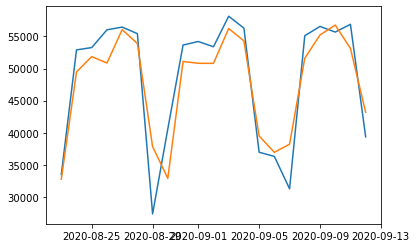

In [343]:
plt.plot(_actual_8['datetime'], _actual_8['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [344]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(3)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(3)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

6992.175600879131

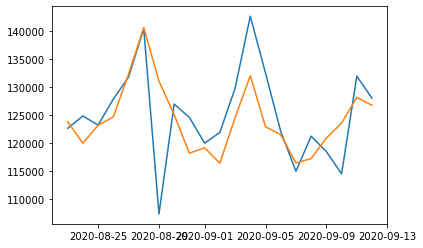

In [345]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [346]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(4)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(4)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4514.007432987268

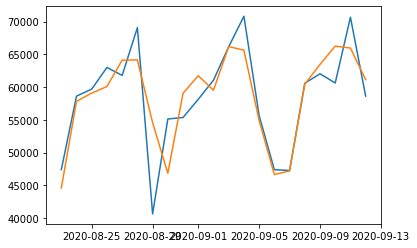

In [347]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [348]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(7)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(7)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4773.048466598711

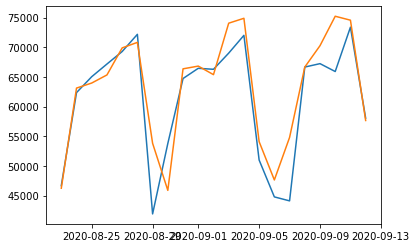

In [349]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [350]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(1)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(1)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

7218.185438239145

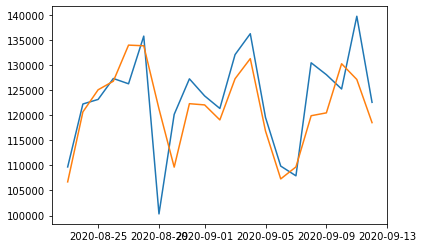

In [351]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [352]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(2)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(2)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

2738.383472305067

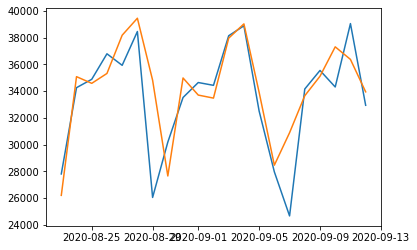

In [353]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [354]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(5)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(5)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4644.5925744054875

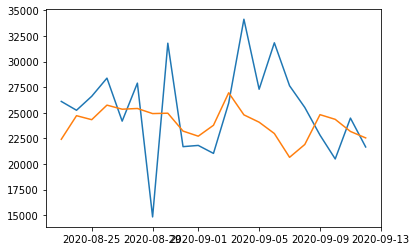

In [355]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [356]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(6)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(6)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

3114.912994526145

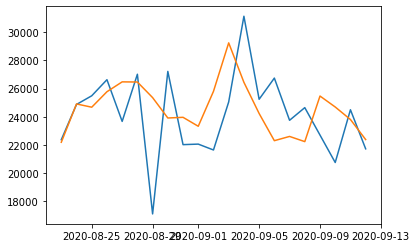

In [357]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [358]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(8)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(8)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

4043.6559914229624

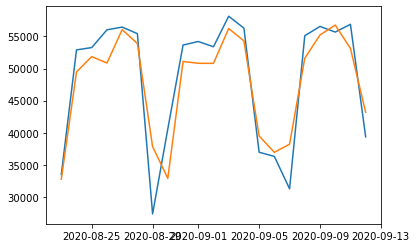

In [359]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [360]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(9)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(9)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

11189.909481761366

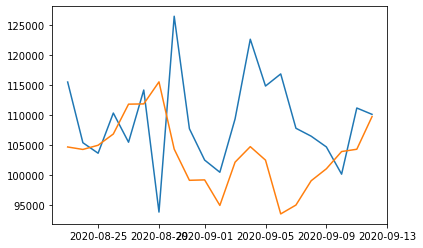

In [361]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])

In [362]:
_actual_3 = test_set.loc[test_set['plaza_id'].eq(10)]
_thirdwhat = _third_concat.loc[_third_concat['plaza_id'].eq(10)]
_thirdwhat1 = _thirdwhat.loc[_thirdwhat['datetime'] >= '2020-08-23']
np.sqrt(mean_squared_error(_thirdwhat1['value'], _actual_3['value']))

6050.5063718844385

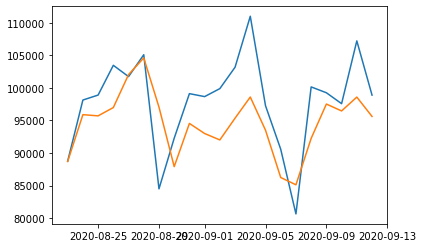

In [363]:
plt.plot(_actual_3['datetime'], _actual_3['value'])
plt.plot(_thirdwhat1['datetime'], _thirdwhat1['value'])